# Домашнее задание к занятию "Введение в нейронные сети"

Антон Уразов

# Реализация логистической регрессии в tensorflow

Реализовать модель логистической регрессии. На базе шаблона 004-classification.ipynb необходимо реализовать операцию sigmoid в моделе логистической регрессии.
Решение необходимо прислать в виде ipython-ноутбука с визуализацией разделяющей гиперплоскости.

In [2]:
import numpy as np
import tensorflow as tf

/Users/antonurazov/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

## Генерируем данные для задачи регрессии

In [4]:
NUM_FEATURES = 2
NUM_SAMPLES = 1000

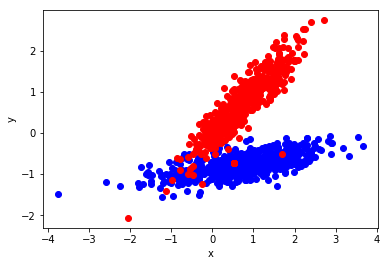

In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples = NUM_SAMPLES,
                           n_features = NUM_FEATURES,
                           n_informative = NUM_FEATURES,
                           n_redundant = 0,
                           n_classes = 2,
                           n_clusters_per_class = 1,
                           class_sep = 0.75,
                           random_state = 54312)

y = y.reshape(-1, 1)

ones = np.where(y == 1)   # индексы объектов класса '1'
zeros = np.where(y == 0)  # индексы объектов класса '0'

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or');

## Вспомогательная функция для создания операций

In [6]:
import random
import string

def py_func_with_grad(func, inp, Tout, grad, name = None, stateful = False, graph = None):
    
    name_prefix = ''.join(random.choices(string.ascii_letters, k = 10))
    
    name = '%s_%s' % (name_prefix, name or '')
    grad_func_name = '%s_grad' % name

    tf.RegisterGradient(grad_func_name)(grad)

    g = graph or tf.get_default_graph()
    with g.gradient_override_map({'PyFunc': grad_func_name, 
                                  'PyFuncStateless': grad_func_name}):
        with tf.name_scope(name, 'PyFuncOp', inp):
            return tf.py_func(func, inp, Tout, stateful = stateful, name = name)

## Реализация линейной опреаций

In [58]:
def linear_op_forward(X, W):
    ''' Реализация линейной операции '''
    return np.dot(X, W.T)  # аргументы являются numpy-массивами

def linear_op_backward(op, grads):
    ''' Реализация вычисления градиента линейной операции '''
    X = op.inputs[0]  # тензор входных данных
    W = op.inputs[1]  # тензор параметров модели
    dX = tf.multiply(grads, W)
    dW = tf.reduce_sum(tf.multiply(X, grads),
                       axis = 0,
                       keep_dims = True)
    return dX, dW

def sigmoid_op_forward(X):
    '''  Реализация операции sigmoid'''
    return np.exp(X) / (np.exp(X) +1)

def sigmoid_op_backward(op, grads):
    ''' Реализация вычисления градиента sigmoid операции '''
    s = op.outputs[0]
    return (1 - s)* s * grads

### Комментарии
Функция sigmoid имеет вид:

$s(x) = \frac{1}{1+e^{-x}}=\frac{e^x}{e^x+1}$.

Почитаем ее производную:

$
\cfrac{\partial s(x)}{\partial x} 
= -1 \cdot (1+e^{-x})^{-2}\cdot(-e^{-x}) 
= e^{-x}\cdot(1+e^{-x})^{-2} 
= \cfrac{e^{-x}}{e^{-x}+1}\cdot \cfrac{1}{e^{-x}+1}
= \cfrac{1}{e^x + 1} \cdot \cfrac{e^x}{e^x+1}
= (1-s(x))\cdot s(x)
$ 

## Создание графа вычислений и обучение модели

In [51]:
BATCH_SIZE = NUM_SAMPLES // 10

weights = None  # в этой переменной мы сохраним результат обучения модели
learning_curve = []  # значения ошибки на каждой итерации обучения

with tf.Session(graph = tf.Graph()) as sess:  # инициализируем сессию вычислений
    
    # создаем placeholdr'ы, через них мы будем
    # передавать внешние данные в граф вычислений
    plh_X = tf.placeholder(dtype = tf.float32, shape = [None, NUM_FEATURES])
    plh_labels = tf.placeholder(dtype = tf.float32, shape = [None, 1])

    # создаем переменную для хранения весов модели
    # эти веса будут изменяться в процессе обучения
    var_W = tf.Variable(tf.random_uniform(shape = [1, NUM_FEATURES],
                                          dtype = tf.float32,
                                          seed = 54321))
    
    # создаем переменную для результата предсказания модели
    var_Pred = py_func_with_grad(linear_op_forward,         # функция предсказания модели 
                                 [plh_X, var_W],            # аргументы функции
                                 [tf.float32],              # тип выходных значений
                                 name = 'linear_op',        # имя операции 
                                 grad = linear_op_backward, # функция для вычисления градиента
                                 graph = sess.graph)        # объект графа вчислений
    
    # создаем переменную для результата операции sigmoid
    var_Sigmoid = py_func_with_grad(sigmoid_op_forward,
                                    [var_Pred],
                                    [tf.float32],
                                    name = 'sigmoid_op',
                                    grad = sigmoid_op_backward,
                                    graph = sess.graph)
    
    # кроссэнтропийная функция потерь для бинарной классификации
    cost = tf.losses.sigmoid_cross_entropy(plh_labels, var_Sigmoid)
    
    # инициализируем оптимизатор и указываем скорость обучения
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.9).minimize(cost)

    # инициализируем placeholder'ы и переменные
    sess.run(tf.global_variables_initializer())
    
    indices = np.arange(len(X))  # массив индексов объектов
    
    # выполняем итерации по 10-ти эпохам
    for epoch in range(50):
        
        # вначале каждой эпохи перемешиваем индексы
        np.random.shuffle(indices)
        
        # внутри каждой эпохи данные разбиваются на батчи
        for batch in range(len(X) // BATCH_SIZE):
            
            # выбираем индексы очередного батча
            batch_indices = indices[batch * BATCH_SIZE:(batch + 1) * BATCH_SIZE]

            # выполняем шаг обучения: вычисляем ошибку и обновляем веса
            loss, _ = sess.run([cost, optimizer],  # указываем, какие операции необходимо выполнить
                               feed_dict = {plh_X: X[batch_indices],  # передаем входные данные для вычисления
                                            plh_labels: y[batch_indices]})
        
            # сохраняем занчения ошибки для построения кривой обучения
            learning_curve.append(loss)
            
            # выводим текущее значение ошибки для каждого 10го шага
            steps = len(learning_curve) - 1
            if steps % 10 == 0:
                print('[%03d] loss=%.3f weights=%s' % (steps, loss, var_W.eval()))
    
    # сохраняем обученные веса
    weights = var_W.eval()

[000] loss=0.737 weights=[[0.41167268 0.1790637 ]]
[010] loss=0.687 weights=[[ 0.16191527 -0.5893183 ]]
[020] loss=0.626 weights=[[ 0.05212637 -1.1919289 ]]
[030] loss=0.612 weights=[[ 0.02860462 -1.6149259 ]]
[040] loss=0.607 weights=[[ 0.04546603 -1.9415412 ]]
[050] loss=0.563 weights=[[ 0.07602676 -2.2081456 ]]
[060] loss=0.594 weights=[[ 0.08115891 -2.4362547 ]]
[070] loss=0.602 weights=[[ 0.10983271 -2.6334414 ]]
[080] loss=0.586 weights=[[ 0.14578578 -2.80693   ]]
[090] loss=0.616 weights=[[ 0.15914066 -2.9612427 ]]
[100] loss=0.577 weights=[[ 0.18113734 -3.1036904 ]]
[110] loss=0.620 weights=[[ 0.18944038 -3.2322717 ]]
[120] loss=0.568 weights=[[ 0.20430104 -3.3504534 ]]
[130] loss=0.595 weights=[[ 0.21625583 -3.4624627 ]]
[140] loss=0.567 weights=[[ 0.22589429 -3.5644083 ]]
[150] loss=0.560 weights=[[ 0.24331327 -3.6621466 ]]
[160] loss=0.570 weights=[[ 0.24989614 -3.7489374 ]]
[170] loss=0.556 weights=[[ 0.2550353 -3.8371475]]
[180] loss=0.601 weights=[[ 0.26376924 -3.9172294 

## Визуализируем кривую обучения

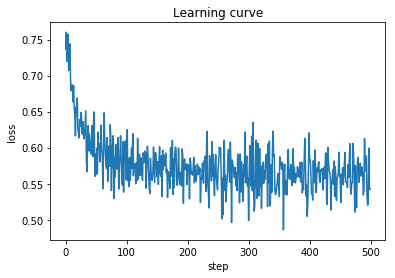

In [52]:
plt.xlabel('step')
plt.ylabel('loss')
plt.title('Learning curve')
plt.plot(learning_curve);

## Визуализируем разделяющую гиперплоскость

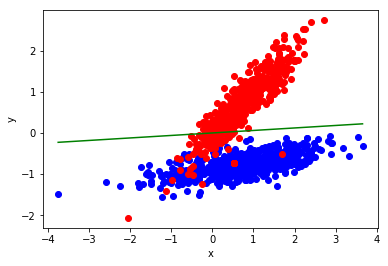

In [53]:
y_pred = - X[:, 0] * weights[0, 0] / weights[0, 1]

order = np.argsort(X[:, 0])

plt.xlabel('x')
plt.ylabel('y')
plt.plot(X[ones, 0], X[ones, 1], 'ob',
         X[zeros, 0], X[zeros, 1], 'or',
         X[order, 0], y_pred[order], '-g');

In [57]:
weights

array([[ 0.33186907, -5.470314  ]], dtype=float32)